
Copyright (c) 2019 Computational-Medicine

# Convert DICOMs to NIFTI using dcm2niix

dcm2niix is a designed to convert neuroimaging data from the DICOM format to the NIfTI format.

This software should run on macOS, Linux and Windows typically without requiring any other software. However, if you use dcm2niix to create gz-compressed images it will be faster if you have pigz installed. You can get a version of both dcm2niix and [pigz](https://github.com/madler/pigz) compiled for your operating system by downloading [MRIcroGL](https://github.com/rordenlab/MRIcroGL12/releases). There is also an optional [batch processing version](https://github.com/rordenlab/dcm2niix/blob/master/BATCH.md) of dcm2niix.


### Install

There are a couple ways to install dcm2niix

 - [Github Releases](https://github.com/rordenlab/dcm2niix/releases) provides the latest compiled executables. This is an excellent option for MacOS and Windows users. However, the provided Linux executable requires a recent version of Linux, so the provided Unix executable is not suitable for all distributions.
 - [MRIcroGL](https://github.com/rordenlab/MRIcroGL12/releases) includes dcm2niix that can be run from the command line or from the graphical user interface (select the Import menu item). The Linux version of dcm2niix is compiled on a holy build box, so it should run on any Linux distribution.
 - If you have a MacOS computer with Homebrew you can run brew install dcm2niix.
 - If you have Conda, `conda install -c conda-forge dcm2niix` on Linux, MacOS or Windows (may be not the latest version)
 - On Debian Linux computers you can run sudo apt-get install dcm2niix.


In [43]:
%matplotlib inline

import os
import os.path as op
from os import listdir
from os.path import isfile, isdir, join
import pathlib
import glob
import shutil
import json
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
from nilearn.image.image import mean_img
from sklearn.cluster import KMeans
from nilearn.masking import apply_mask
from pprint import pprint

import nilearn
import sklearn
import matplotlib
import pydicom  # pip install git+https://github.com/pydicom/pydicom.git
import pydicom as dicom

print('numpy: %s' % np.__version__)
print('pandas: %s' % pd.__version__)
print('nibabel: %s' % nib.__version__)
print('scipy: %s' % scipy.__version__)
print('nilearn: %s' % nilearn.__version__)
print('matplotlib: %s' % matplotlib.__version__)
print('sklearn: %s' % sklearn.__version__)
print('pydicom: %s' % pydicom.__version__)
print('json: %s' % json.__version__)

numpy: 1.14.5
pandas: 0.23.4
nibabel: 2.3.2
scipy: 1.1.0
nilearn: 0.5.0
matplotlib: 3.0.2
sklearn: 0.20.0
pydicom: 1.2.2
json: 2.0.9


In [69]:
import os
import pathlib
import pandas as pd
import numpy as np
home = os.path.expanduser('~')  # To make path to local home directory

# We assume you have made a directory ~/prj/BMED360/data

### Download zipped DICOM data from a Google Drive

https://drive.google.com/file/d/1S-Og-5-T8N8wxfqR4hm2bFrP0pEsaliN/view?usp=sharing

In [70]:
# https://github.com/nsadawi/Download-Large-File-From-Google-Drive-Using-Python/blob/master/Download-Large-File-from-Google-Drive.ipynb

# taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [9]:
file_id = '1S-Og-5-T8N8wxfqR4hm2bFrP0pEsaliN'
destination = '%s/prj/BMED360/data/lg_prisma_20160218.zip' % (home)
download_file_from_google_drive(file_id, destination)

### Unzip DICOM files to a target directory

https://stackoverflow.com/questions/3451111/unzipping-files-in-python

In [76]:
from zipfile import ZipFile

path_to_extract_folder = '%s/prj/BMED360/data' % (home)
zf = ZipFile(destination, 'r')
zf.extractall(path_to_extract_folder)
zf.close()

In [77]:
#!tree path_to_extract_folder /f /a
cmd = 'tree %s /a' % (path_to_extract_folder)
print(os.popen(cmd).read())

Folder PATH listing for volume Local Disk
Volume serial number is 82A6-EE0C
C:\USERS\ARVID\PRJ\BMED360\DATA
\---lg_prisma_20160218
    \---dicom



## dcm2niix

https://github.com/rordenlab/dcm2niix

git clone git@github.com:rordenlab/dcm2niix.git

https://www.nitrc.org/plugins/mwiki/index.php/dcm2nii:MainPage

conda install -c conda-forge dcm2niix

Download: https://github.com/rordenlab/dcm2niix <br>
Usage: https://www.nitrc.org/plugins/mwiki/index.php/dcm2nii:MainPage#General_Usage

In [78]:
DCMCONVERT = '%s/prj/BMED360/bin/dcm2niix_11-Apr-2019_win/dcm2niix.exe' % (home)
print(os.popen(DCMCONVERT).read())

Compression will be faster with pigz.exe in the same folder as the executable
Chris Rorden's dcm2niiX version v1.0.20190410  (JP2:OpenJPEG) (JP-LS:CharLS) MSC1900 (64-bit Windows)
usage: dcm2niix.exe [options] <in_folder>
 Options :
  -1..-9 : gz compression level (1=fastest..9=smallest, default 6)
  -a : adjacent DICOMs (images from same series always in same folder) for faster conversion (n/y, default n)
  -b : BIDS sidecar (y/n/o [o=only: no NIfTI], default y)
   -ba : anonymize BIDS (y/n, default y)
  -c : comment stored in NIfTI aux_file (provide up to 24 characters)
  -d : directory search depth. Convert DICOMs in sub-folders of in_folder? (0..9, default 5)
  -e : export as NRRD instead of NIfTI (y/n, default n)
  -f : filename (%a=antenna (coil) name, %b=basename, %c=comments, %d=description, %e=echo number, %f=folder name, %i=ID of patient, %j=seriesInstanceUID, %k=studyInstanceUID, %m=manufacturer, %n=name of patient, %p=protocol, %r=instance number, %s=series number, %t=time,

In [82]:
subjs = ['lg_prisma_20160218']
mydcm = '%s/%s/dicom' % (path_to_extract_folder, subj)
mynii = '%s/%s/nifti' % (path_to_extract_folder, subj)

In [83]:
def my_dcm2niix(mydcm, mynii, subj):
    for i in range(len(subj)):
        s = subj[i]
    
        # Convert to NIFTI (all sequences)
        source_dir = mydcm
        output_dir = mynii
        pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
    
        # cmd = [
        # '/usr/local/bin/dcm2niix',
        # '/home/arvid/anaconda3/bin/dcm2niix',
        # 'C:\\Users\\arvid\\Anaconda3\\Library\\bin\\dcm2niix',
        # 'C:\Users\arvid\Anaconda3\Library\bin\dcm2niix.exe'
        cmd = [
            DCMCONVERT,
            '-d', '9',
            '-b', 'y',
            '-m', 'n',
            '-s', 'n',
            '-t', 'n',
            '-x', 'n',
            '-z', 'y',
            '-i', 'y',
            '-f', subj[i]+'_%s_%p_%n_%t',
            '-o', output_dir,
            source_dir]
        #  '-f', '%p_%t_%s',    see help:  dcm2niix -h
        cmd_str = " ".join(cmd)
        print('cmd_str = \n%s\n' % cmd_str)
        os.system(cmd_str)

In [84]:
my_dcm2niix(mydcm, mynii, subjs)

cmd_str = 
C:\Users\arvid/prj/BMED360/bin/dcm2niix_11-Apr-2019_win/dcm2niix.exe -d 9 -b y -m n -s n -t n -x n -z y -i y -f lg_prisma_20160218_%s_%p_%n_%t -o C:\Users\arvid/prj/BMED360/data/lg_prisma_20160218/nifti C:\Users\arvid/prj/BMED360/data/lg_prisma_20160218/dicom



## BIDS

http://reproducibility.stanford.edu/bids-tutorial-series-part-1a/

BIDS validator: http://bids-standard.github.io/bids-validator

In [119]:
# BIDSHOME = '/mnt/c/Users/arvid/prj/BrainGut/my_bids'
BIDSHOME = 'C:/Users/arvid/prj/Aging/bids'
myBIDSHOME = 'C:/Users/arvid/prj/Aging/my_bids'

In [120]:
cmd = 'ls -al %s' % (BIDSHOME)
process = os.popen(cmd)
o=process.read()
print(o)
process.close()

total 14
drwxr-xr-x 1 arvid arvid   0 Feb 19 20:51 .
drwxr-xr-x 1 arvid arvid   0 Feb 19 21:43 ..
-rw-r--r-- 1 arvid arvid 274 Feb 19 20:51 dataset_description.json
-rw-r--r-- 1 arvid arvid 557 Feb 19 21:04 participants.json
-rw-r--r-- 1 arvid arvid 159 Feb 19 20:54 participants.tsv
drwxr-xr-x 1 arvid arvid   0 Feb 19 20:38 sub-501
drwxr-xr-x 1 arvid arvid   0 Feb 19 20:40 sub-502
drwxr-xr-x 1 arvid arvid   0 Feb 19 20:37 sub-504
drwxr-xr-x 1 arvid arvid   0 Feb 19 20:39 sub-505
drwxr-xr-x 1 arvid arvid   0 Feb 19 20:37 sub-506
drwxr-xr-x 1 arvid arvid   0 Feb 19 20:41 sub-507
drwxr-xr-x 1 arvid arvid   0 Feb 19 20:41 sub-508
drwxr-xr-x 1 arvid arvid   0 Feb 19 20:41 sub-510



In [121]:
# Linux: cmd = 'tree %s' % (BIDSHOME)
cmd = 'tree %s /f /a' % (BIDSHOME)
process = os.popen(cmd)
o=process.read()
print(o)
process.close()

Folder PATH listing for volume Local Disk
Volume serial number is 82A6-EE0C
C:\USERS\ARVID\PRJ\AGING\BIDS
|   dataset_description.json
|   participants.json
|   participants.tsv
|   
+---sub-501
|   +---ses-01
|   |   +---anat
|   |   |       sub-501_ses-01_T1w.json
|   |   |       sub-501_ses-01_T1w.nii.gz
|   |   |       sub-501_ses-01_T2w.json
|   |   |       sub-501_ses-01_T2w.nii.gz
|   |   |       
|   |   \---dwi
|   |           sub-501_ses-01_dwi.bval
|   |           sub-501_ses-01_dwi.bvec
|   |           sub-501_ses-01_dwi.json
|   |           sub-501_ses-01_dwi.nii.gz
|   |           
|   \---ses-02
|       +---anat
|       |       sub-501_ses-02_T1w.json
|       |       sub-501_ses-02_T1w.nii.gz
|       |       sub-501_ses-02_T2w.json
|       |       sub-501_ses-02_T2w.nii.gz
|       |       
|       +---dwi
|       |       sub-501_ses-02_dwi.bval
|       |       sub-501_ses-02_dwi.bvec
|       |       sub-501_ses-02_dwi.json
|       |       sub-501_ses-02_dwi.nii.gz
|     

In [122]:
# Linux: cmd = 'tree %s' % (BIDSHOME)
cmd = 'tree %s /f /a' % (myBIDSHOME)
process = os.popen(cmd)
o=process.read()
print(o)
process.close()

Folder PATH listing for volume Local Disk
Volume serial number is 82A6-EE0C
C:\USERS\ARVID\PRJ\AGING\MY_BIDS
|   dataset_description.json
|   participants.json
|   participants.tsv
|   
\---sub-507
    +---ses-01
    |   +---anat
    |   |       sub-507_ses-01_acq-1_T1w.json
    |   |       sub-507_ses-01_acq-1_T1w.nii.gz
    |   |       sub-507_ses-01_acq-2_T1w.json
    |   |       sub-507_ses-01_acq-2_T1w.nii.gz
    |   |       
    |   \---dwi
    |           sub-507_ses-01_dwi.bval
    |           sub-507_ses-01_dwi.bvec
    |           sub-507_ses-01_dwi.json
    |           sub-507_ses-01_dwi.nii.gz
    |           
    +---ses-02
    |   +---anat
    |   |       sub-507_ses-02_acq-1_T1w.json
    |   |       sub-507_ses-02_acq-1_T1w.nii.gz
    |   |       sub-507_ses-02_acq-2_T1w.json
    |   |       sub-507_ses-02_acq-2_T1w.nii.gz
    |   |       
    |   +---dwi
    |   |       sub-507_ses-02_dwi.bval
    |   |       sub-507_ses-02_dwi.bvec
    |   |       sub-507_ses-02_dwi.js

Command line version:
Install [Node.js](https://nodejs.org) (at least version 8.0)<br>
From a terminal run `npm install -g bids-validator`<br>
Run `bids-validator` to start validating datasets.

In [161]:
cmd = 'bids-validator %s --verbose' % myBIDSHOME
process = os.popen(cmd)
o=process.read()
print(o)
process.close()

	1: [WARN] You should define 'SliceTiming' for this file. If you don't provide this information slice time correction will not be possible. (code: 13 - SLICE_TIMING_NOT_DEFINED)
		./sub-507/ses-03/func/sub-507_ses-03_task-rest_bold.nii.gz
			You should define 'SliceTiming' for this file. If you don't provide this information slice time correction will not be possible. It can be included one of the following locations: /task-rest_bold.json, /bold.json, /sub-507/sub-507_task-rest_bold.json, /sub-507/sub-507_bold.json, /sub-507/ses-03/sub-507_ses-03_task-rest_bold.json, /sub-507/ses-03/sub-507_ses-03_bold.json, /sub-507/ses-03/func/sub-507_ses-03_task-rest_bold.json, /sub-507/ses-03/func/sub-507_ses-03_bold.json

        Summary:                  Available Tasks:        Available Modalities: 
        31 Files, 236.85MB        rest                    /participants         
        1 - Subject                                       T1w                   
        3 - Sessions                 

In [124]:
fn = BIDSHOME+'/participants.json'
fn

'C:/Users/arvid/prj/Aging/bids/participants.json'

In [125]:
with open(fn) as data_file:    
    data = json.load(data_file)

In [126]:
data.keys()

dict_keys(['age', 'gender', 'group', 'participant_id'])

In [127]:
# Rename dictionary key
#data['group'] = data.pop('cat')

In [128]:
pprint(data)

{'age': {'Description': 'age of the participant', 'Units': 'years'},
 'gender': {'Description': 'sex of the participant',
            'Levels': {'F': 'female', 'M': 'male'}},
 'group': {'Description': 'group the participant belonged to in the study',
           'Levels': {'HC': 'Healthy control',
                      'IBS': 'Irritable bowel syndrome'}},
 'participant_id': {'Description': 'id of the participant'}}


In [129]:
pprint(data['group']['Levels']['IBS'])

'Irritable bowel syndrome'


In [130]:
data['group']['Levels']['IBS'] = 'Irritable bowel syndrome'

In [131]:
pprint(data)

{'age': {'Description': 'age of the participant', 'Units': 'years'},
 'gender': {'Description': 'sex of the participant',
            'Levels': {'F': 'female', 'M': 'male'}},
 'group': {'Description': 'group the participant belonged to in the study',
           'Levels': {'HC': 'Healthy control',
                      'IBS': 'Irritable bowel syndrome'}},
 'participant_id': {'Description': 'id of the participant'}}


In [132]:
pprint(data['participant_id'])

{'Description': 'id of the participant'}


In [134]:
with open(fn, 'w') as outfile:
    json.dump(data, outfile, sort_keys=True, indent=4)

In [158]:
# fn1 = myBIDSHOME+'/sub-507/ses-01/func/sub-507_ses-01_task-rest_bold.json'
fn2 = myBIDSHOME+'/sub-507/ses-02/func/sub-507_ses-02_task-rest_bold.json'
fn3 = myBIDSHOME+'/sub-507/ses-03/func/sub-507_ses-03_task-rest_bold.json'

In [160]:
with open(fn2) as data_file2:    
    data2 = json.load(data_file2)
    pprint(data2)

{'AcquisitionMatrixPE': 64,
 'AcquisitionNumber': 1,
 'AcquisitionTime': '15:10:6.000000',
 'CoilString': '8HRBRAIN',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20181114  MSC1900',
 'DeviceSerialNumber': '000000NO1146MR01',
 'EchoTime': 0.05,
 'EffectiveEchoSpacing': 0.000464,
 'FlipAngle': 90,
 'ImageOrientationPatientDICOM': [1, 0, 0, 0, 1, 0],
 'ImageType': ['ORIGINAL', 'PRIMARY', 'EPI', 'NONE'],
 'ImagingFrequency': 63.8442,
 'InPlanePhaseEncodingDirectionDICOM': 'COL',
 'InstitutionName': 'DS_Haraldsplass',
 'MRAcquisitionType': '2D',
 'MagneticFieldStrength': 1.5,
 'Manufacturer': 'GE',
 'ManufacturersModelName': 'SIGNA_EXCITE',
 'Modality': 'MR',
 'PatientPosition': 'HFS',
 'PercentPhaseFOV': 100,
 'PhaseEncodingDirection': 'j-',
 'PhaseEncodingPolarityGE': 'Unflipped',
 'PixelBandwidth': 7812.5,
 'ProcedureStepDescription': 'AGING',
 'ProtocolName': 'AX_fMRI_GRE_EPI_RESTING',
 'ReconMatrixPE': 64,
 'RepetitionTime': 2,
 'SAR': 0.0235439,
 'ScanOption

**TaskName**

Let's begin with the defining `TaskName`. To do this, we will be editing the functional scan's json files. There are required fields that need to be present in each func json file. For this dataset, we notice upon opening the json's that they have defined repetition time and slice timing, but not task name. The task name needs to be the same name given as the task-<TaskName> in the filename. For example sub-101_ses-1_task-rest_bold.json ; the json will have 'TaskName': 'rest, 

In [147]:
data2.items()

dict_items([('Modality', 'MR'), ('MagneticFieldStrength', 1.5), ('ImagingFrequency', 63.8442), ('Manufacturer', 'GE'), ('ManufacturersModelName', 'SIGNA_EXCITE'), ('InstitutionName', 'DS_Haraldsplass'), ('DeviceSerialNumber', '000000NO1146MR01'), ('StationName', 'GEMSOW'), ('PatientPosition', 'HFS'), ('ProcedureStepDescription', 'AGING'), ('SoftwareVersions', '12_LX_MR_Software_release:12.0_M5A_0819.a'), ('MRAcquisitionType', '2D'), ('SeriesDescription', 'AX_fMRI_GRE_EPI_RESTING'), ('ProtocolName', 'AX_fMRI_GRE_EPI_RESTING'), ('ScanningSequence', 'EP_GR'), ('SequenceVariant', 'SS'), ('ScanOptions', 'EPI_GEMS_PFF'), ('ImageType', ['ORIGINAL', 'PRIMARY', 'EPI', 'NONE']), ('SeriesNumber', 5), ('AcquisitionTime', '15:10:6.000000'), ('AcquisitionNumber', 1), ('SliceThickness', 5), ('SpacingBetweenSlices', 5.5), ('SAR', 0.0235439), ('EchoTime', 0.05), ('RepetitionTime', 2), ('FlipAngle', 90), ('PhaseEncodingPolarityGE', 'Unflipped'), ('CoilString', '8HRBRAIN'), ('PercentPhaseFOV', 100), ('Ac

In [148]:
data2.update({'TaskName': 'rest'})
pprint(data2)

{'AcquisitionMatrixPE': 64,
 'AcquisitionNumber': 1,
 'AcquisitionTime': '15:10:6.000000',
 'CoilString': '8HRBRAIN',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20181114  MSC1900',
 'DeviceSerialNumber': '000000NO1146MR01',
 'EchoTime': 0.05,
 'EffectiveEchoSpacing': 0.000464,
 'FlipAngle': 90,
 'ImageOrientationPatientDICOM': [1, 0, 0, 0, 1, 0],
 'ImageType': ['ORIGINAL', 'PRIMARY', 'EPI', 'NONE'],
 'ImagingFrequency': 63.8442,
 'InPlanePhaseEncodingDirectionDICOM': 'COL',
 'InstitutionName': 'DS_Haraldsplass',
 'MRAcquisitionType': '2D',
 'MagneticFieldStrength': 1.5,
 'Manufacturer': 'GE',
 'ManufacturersModelName': 'SIGNA_EXCITE',
 'Modality': 'MR',
 'PatientPosition': 'HFS',
 'PercentPhaseFOV': 100,
 'PhaseEncodingDirection': 'j-',
 'PhaseEncodingPolarityGE': 'Unflipped',
 'PixelBandwidth': 7812.5,
 'ProcedureStepDescription': 'AGING',
 'ProtocolName': 'AX_fMRI_GRE_EPI_RESTING',
 'ReconMatrixPE': 64,
 'RepetitionTime': 2,
 'SAR': 0.0235439,
 'ScanOption

In [149]:
with open(fn2) as data_file2:    
    data2 = json.load(data_file2)
data2.update({'TaskName': 'rest'})
pprint(data2)

{'AcquisitionMatrixPE': 64,
 'AcquisitionNumber': 1,
 'AcquisitionTime': '15:10:6.000000',
 'CoilString': '8HRBRAIN',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20181114  MSC1900',
 'DeviceSerialNumber': '000000NO1146MR01',
 'EchoTime': 0.05,
 'EffectiveEchoSpacing': 0.000464,
 'FlipAngle': 90,
 'ImageOrientationPatientDICOM': [1, 0, 0, 0, 1, 0],
 'ImageType': ['ORIGINAL', 'PRIMARY', 'EPI', 'NONE'],
 'ImagingFrequency': 63.8442,
 'InPlanePhaseEncodingDirectionDICOM': 'COL',
 'InstitutionName': 'DS_Haraldsplass',
 'MRAcquisitionType': '2D',
 'MagneticFieldStrength': 1.5,
 'Manufacturer': 'GE',
 'ManufacturersModelName': 'SIGNA_EXCITE',
 'Modality': 'MR',
 'PatientPosition': 'HFS',
 'PercentPhaseFOV': 100,
 'PhaseEncodingDirection': 'j-',
 'PhaseEncodingPolarityGE': 'Unflipped',
 'PixelBandwidth': 7812.5,
 'ProcedureStepDescription': 'AGING',
 'ProtocolName': 'AX_fMRI_GRE_EPI_RESTING',
 'ReconMatrixPE': 64,
 'RepetitionTime': 2,
 'SAR': 0.0235439,
 'ScanOption

In [151]:
with open(fn3) as data_file3:    
    data3 = json.load(data_file3)
data3.update({'TaskName': 'rest'})
pprint(data3)

{'AcquisitionMatrixPE': 64,
 'AcquisitionNumber': 1,
 'AcquisitionTime': '11:49:56.000000',
 'CoilString': '8HRBRAIN',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20181114  MSC1900',
 'DeviceSerialNumber': '000000NO1146MR01',
 'EchoTime': 0.05,
 'EffectiveEchoSpacing': 0.000464,
 'FlipAngle': 90,
 'ImageOrientationPatientDICOM': [1, 0, 0, 0, 0.978081, -0.208226],
 'ImageType': ['ORIGINAL', 'PRIMARY', 'EPI', 'NONE'],
 'ImagingFrequency': 63.844,
 'InPlanePhaseEncodingDirectionDICOM': 'COL',
 'InstitutionName': 'DS_Haraldsplass',
 'MRAcquisitionType': '2D',
 'MagneticFieldStrength': 1.5,
 'Manufacturer': 'GE',
 'ManufacturersModelName': 'SIGNA_EXCITE',
 'Modality': 'MR',
 'PatientPosition': 'HFS',
 'PercentPhaseFOV': 100,
 'PhaseEncodingDirection': 'j-',
 'PhaseEncodingPolarityGE': 'Unflipped',
 'PixelBandwidth': 7812.5,
 'ProtocolName': 'AX_fMRI_GRE_EPI_RESTING',
 'ReconMatrixPE': 64,
 'RepetitionTime': 2,
 'SAR': 0.0235439,
 'ScanOptions': 'EPI_GEMS_PFF',
 'S

In [152]:
with open(fn2, 'w') as outfile2:
    json.dump(data2, outfile2, sort_keys=True, indent=4)

In [153]:
with open(fn3, 'w') as outfile3:
    json.dump(data3, outfile3, sort_keys=True, indent=4)

**SliceTiming**

RECOMMENDED. The time at which each slice was acquired within each volume (frame) of the acquisition. Slice timing is not slice order -- rather, it is a list of times (in JSON format) containing the time (in seconds) of each slice acquisition in relation to the beginning of volume acquisition. The list goes through the slices along the slice axis in the slice encoding dimension (see below). Note that to ensure the proper interpretation of the `SliceTiming` field, it is important to check if the OPTIONAL `SliceEncodingDirection` exists. In particular, if `SliceEncodingDirection` is negative, the entries in `SliceTiming` are defined in reverse order with respect to the slice axis (i.e., the final entry in the `SliceTiming` list is the time of acquisition of slice 0). This parameter is REQUIRED for sparse sequences that do not have the DelayTime field set. In addition without this parameter slice time correction will not be possible.

Please note that some DICOM parameters have been traditionally expressed in milliseconds. Those need to be converted to seconds.

See also: https://github.com/rordenlab/dcm2niix/issues/163   and https://github.com/rordenlab/dcm2niix/tree/master/GE

One other suggestion - you may want to try [Xiangrui Li's dicm2nii](https://www.mathworks.com/matlabcentral/fileexchange/42997-dicom-to-nifti-converter--nifti-tool-and-viewer). I think he devoted more time than me in attempting to decode GE datasets. You may find that it provides a richer set of BIDS data than dcm2niix.

In [155]:
st2 = data2['SliceTiming']
print(st2)
arr2 = np.array(st2)
print(list(arr2/1000))
#data1['SliceTiming'] = list(arr1/10000)

KeyError: 'SliceTiming'

From dicm2nii.m 20190214 

```python
>> addpath 'C:/Users/arvid/GitHub/dicm2nii' -end
>> >> dicm2nii('D:/Aging/Dicom/Wave2/subj_507', 'C:\Users\arvid\prj\Aging\Nifti_dicm2nii\Wave2\subj_507', 'bids');

With GUI entries:
    
sub-507_ses-02_T2star.json


"ConversionSoftware": "dicm2nii.m 20190214",
	"SeriesNumber": 5,
	"SeriesDescription": "AX fMRI_GRE_EPI RESTING",
	"ImageType": ["ORIGINAL", "PRIMARY", "EPI", "NONE"],
	"Modality": "MR",
	"AcquisitionDateTime": "20090207151006",
	"TotalReadoutTime": 0.029232,
``` 
	"SliceTiming": [
		0.96,
		1.92,
		0.88,
		1.84,
		0.8,
		1.76,
		0.72,
		1.68,
		0.64,
		1.6,
		0.56,
		1.52,
		0.48,
		1.44,
		0.4,
		1.36,
		0.32,
		1.28,
		0.24,
		1.2,
		0.16,
		1.12,
		0.08,
		1.04,
		0	],
```python
	"RepetitionTime": 2,
	"PhaseEncodingDirection": "j-",
	"EffectiveEchoSpacing": 0.000464,
	"EchoTime": 0.05,
	"InversionTime": 0,
	"PatientName": "AGING_2009_02_07_ITH",
	"PatientSex": "F",
	"PatientAge": "060Y",
	"PatientWeight": 66,
	"PatientPosition": "HFS",
	"SliceThickness": 5,
	"FlipAngle": 90,
	"Manufacturer": "GE MEDICAL SYSTEMS",
	"SoftwareVersion": "12\\LX\\MR Software release:12.0_M5A_0819.a",
	"MRAcquisitionType": "2D",
	"InstitutionName": "DS Haraldsplass",
	"DeviceSerialNumber": "000000NO1146MR01",
	"ScanningSequence": "EP\\GR",
	"SequenceVariant": "SS",
	"ScanOptions": "EPI_GEMS\\PFF",
	"SequenceName": "EPI"
}
``` 

In [156]:
data2['SliceTiming'] =[
    0.96,
    1.92,
    0.88,
    1.84,
    0.8,
    1.76,
    0.72,
    1.68,
    0.64,
    1.6,
    0.56,
    1.52,
    0.48,
    1.44,
    0.4,
    1.36,
    0.32,
    1.28,
    0.24,
    1.2,
    0.16,
    1.12,
    0.08,
    1.04,
    0]   

In [157]:
with open(fn2, 'w') as outfile2:
    json.dump(data2, outfile2, sort_keys=True, indent=4)

In [162]:
st3 = data3['SliceTiming']
print(st3)
arr3 = np.array(st3)
print(list(arr2/1000))
#data2['SliceTiming'] = list(arr2/1000)

KeyError: 'SliceTiming'

Similar for Wave3 (sub-507_ses-03_T2star.json) <br>
"AcquisitionDateTime": "20110515114956", <br>
"TotalReadoutTime": 0.029232,

In [163]:
data3['SliceTiming'] = [0.96, 1.92, 0.88, 1.84, 0.8, 1.76, 0.72, 1.68, 0.64, 1.6, 0.56, 1.52, 0.48, 1.44, 0.4, 1.36, 0.32, 1.28, 0.24, 1.2, 0.16, 1.12, 0.08, 1.04, 0]

In [164]:
with open(fn3, 'w') as outfile3:
    json.dump(data3, outfile3, sort_keys=True, indent=4)

In [165]:
pprint(data2)

{'AcquisitionMatrixPE': 64,
 'AcquisitionNumber': 1,
 'AcquisitionTime': '15:10:6.000000',
 'CoilString': '8HRBRAIN',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20181114  MSC1900',
 'DeviceSerialNumber': '000000NO1146MR01',
 'EchoTime': 0.05,
 'EffectiveEchoSpacing': 0.000464,
 'FlipAngle': 90,
 'ImageOrientationPatientDICOM': [1, 0, 0, 0, 1, 0],
 'ImageType': ['ORIGINAL', 'PRIMARY', 'EPI', 'NONE'],
 'ImagingFrequency': 63.8442,
 'InPlanePhaseEncodingDirectionDICOM': 'COL',
 'InstitutionName': 'DS_Haraldsplass',
 'MRAcquisitionType': '2D',
 'MagneticFieldStrength': 1.5,
 'Manufacturer': 'GE',
 'ManufacturersModelName': 'SIGNA_EXCITE',
 'Modality': 'MR',
 'PatientPosition': 'HFS',
 'PercentPhaseFOV': 100,
 'PhaseEncodingDirection': 'j-',
 'PhaseEncodingPolarityGE': 'Unflipped',
 'PixelBandwidth': 7812.5,
 'ProcedureStepDescription': 'AGING',
 'ProtocolName': 'AX_fMRI_GRE_EPI_RESTING',
 'ReconMatrixPE': 64,
 'RepetitionTime': 2,
 'SAR': 0.0235439,
 'ScanOption

In [167]:
pprint(data3)

{'AcquisitionMatrixPE': 64,
 'AcquisitionNumber': 1,
 'AcquisitionTime': '11:49:56.000000',
 'CoilString': '8HRBRAIN',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20181114  MSC1900',
 'DeviceSerialNumber': '000000NO1146MR01',
 'EchoTime': 0.05,
 'EffectiveEchoSpacing': 0.000464,
 'FlipAngle': 90,
 'ImageOrientationPatientDICOM': [1, 0, 0, 0, 0.978081, -0.208226],
 'ImageType': ['ORIGINAL', 'PRIMARY', 'EPI', 'NONE'],
 'ImagingFrequency': 63.844,
 'InPlanePhaseEncodingDirectionDICOM': 'COL',
 'InstitutionName': 'DS_Haraldsplass',
 'MRAcquisitionType': '2D',
 'MagneticFieldStrength': 1.5,
 'Manufacturer': 'GE',
 'ManufacturersModelName': 'SIGNA_EXCITE',
 'Modality': 'MR',
 'PatientPosition': 'HFS',
 'PercentPhaseFOV': 100,
 'PhaseEncodingDirection': 'j-',
 'PhaseEncodingPolarityGE': 'Unflipped',
 'PixelBandwidth': 7812.5,
 'ProtocolName': 'AX_fMRI_GRE_EPI_RESTING',
 'ReconMatrixPE': 64,
 'RepetitionTime': 2,
 'SAR': 0.0235439,
 'ScanOptions': 'EPI_GEMS_PFF',
 'S

In [168]:
df = pd.read_csv('%s/participants.tsv' % (myBIDSHOME), delimiter='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
participant_id    1 non-null object
gender            1 non-null object
age               1 non-null int64
group             1 non-null object
dtypes: int64(1), object(3)
memory usage: 112.0+ bytes


In [169]:
df.head()

,participant_id,gender,age,group
0,sub-507,M,27,HC


In [38]:
# data = pd.read_csv('../data/sympt_soup_gender_f_0_m_1_ibs_0_hc_1.csv') 

In [39]:
# data.head()

,ID,Gender,Age,Patient,pre.suppe.smerter,pre.suppe.kvalme,pre.suppe.oppfylt,pre.suppe.totalt,pre.suppe.mett,post.suppe.smerter,post.suppe.kvalme,post.suppe.oppfylt,post.suppe.totalt,post.suppe.mett,Antall glass,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,101,1,27,1,0.0,0.0,1.0,1.0,23.0,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN
1,102,1,31,1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,19.0,3.0,20.0,3,NaN,NaN,NaN
2,103,0,26,1,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,3,NaN,NaN,NaN
3,104,0,26,1,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,18.0,3,NaN,NaN,NaN
4,105,0,27,1,0.0,0.0,0.0,12.0,0.0,0.0,0.0,36.0,0.0,36.0,3,NaN,NaN,NaN


In [170]:
# participants.tsv
df = pd.DataFrame({'participant_id': ['sub-507'],
                  'gender': ['M'],
                  'age': [27],
                  'group': ['HC']})
df.head()

,participant_id,gender,age,group
0,sub-507,M,27,HC


In [41]:
#df.to_csv('%s/participants.tsv' % (BIDSHOME), sep='\t', encoding='utf-8', index=False )

**Finalk check of BIDS compliance**

In [171]:
cmd = 'bids-validator %s --verbose' % myBIDSHOME
process = os.popen(cmd)
o=process.read()
print(o)
process.close()

This dataset appears to be BIDS compatible.
        Summary:                  Available Tasks:        Available Modalities: 
        31 Files, 236.85MB        rest                    /participants         
        1 - Subject                                       T1w                   
        3 - Sessions                                      dwi                   
                                                          bold                  

If you have any questions please post on https://neurostars.org/tags/bids




In [173]:
# cmd = 'tree %s ' % (myBIDSHOME)
cmd = 'tree %s /f /a' % (myBIDSHOME)
process = os.popen(cmd)
o=process.read()
print(o)
process.close()

Folder PATH listing for volume Local Disk
Volume serial number is 82A6-EE0C
C:\USERS\ARVID\PRJ\AGING\MY_BIDS
|   dataset_description.json
|   participants.json
|   participants.tsv
|   
\---sub-507
    +---ses-01
    |   +---anat
    |   |       sub-507_ses-01_acq-1_T1w.json
    |   |       sub-507_ses-01_acq-1_T1w.nii.gz
    |   |       sub-507_ses-01_acq-2_T1w.json
    |   |       sub-507_ses-01_acq-2_T1w.nii.gz
    |   |       
    |   \---dwi
    |           sub-507_ses-01_dwi.bval
    |           sub-507_ses-01_dwi.bvec
    |           sub-507_ses-01_dwi.json
    |           sub-507_ses-01_dwi.nii.gz
    |           
    +---ses-02
    |   +---anat
    |   |       sub-507_ses-02_acq-1_T1w.json
    |   |       sub-507_ses-02_acq-1_T1w.nii.gz
    |   |       sub-507_ses-02_acq-2_T1w.json
    |   |       sub-507_ses-02_acq-2_T1w.nii.gz
    |   |       
    |   +---dwi
    |   |       sub-507_ses-02_dwi.bval
    |   |       sub-507_ses-02_dwi.bvec
    |   |       sub-507_ses-02_dwi.js

**Inspect images**

In [44]:
# freeview -v ./sub-101/ses-1/anat/sub-101_ses-1_T1w.nii.gz ./sub-101/ses-1/func/sub-101_ses-1_task-rest_bold.nii.gz

In [174]:
anat_fn2 = myBIDSHOME+'/sub-507/ses-02/anat/sub-507_ses-02_acq-1_T1w.nii.gz'
func_fn2 = myBIDSHOME+'/sub-507/ses-02/func/sub-507_ses-02_task-rest_bold.nii.gz'
anat_fn3 = myBIDSHOME+'/sub-507/ses-03/anat/sub-507_ses-03_acq-2_T1w.nii.gz'
func_fn3 = myBIDSHOME+'/sub-507/ses-03/func/sub-507_ses-03_task-rest_bold.nii.gz'

C:\Users\arvid\Anaconda3\lib\site-packages\scipy\ndimage\measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


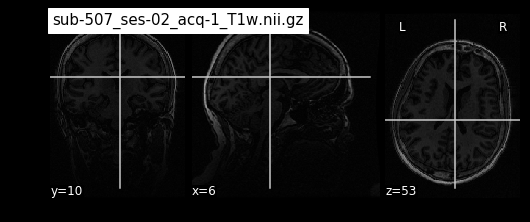

In [175]:
# inspect the resulting NIFTI file using plotting from nilearn
plotting.plot_anat(anat_fn2, title="sub-507_ses-02_acq-1_T1w.nii.gz")

In [176]:
print(image.load_img(anat_fn2).shape)

(124, 256, 256)


In [177]:
# using nibabel
img = nib.load(anat_fn2)
data = img.get_data()
print(data.shape)

(124, 256, 256)


In [178]:
# check the dimensions of each voxel
print(img.header.get_zooms()[:3])

(1.4, 0.9375, 0.9375)


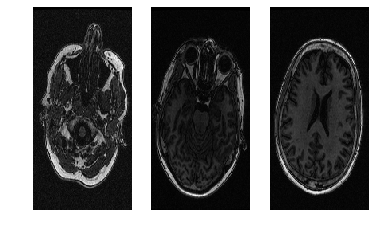

In [179]:
# show here the middle axial slices of 3D T1 image +/- offset slices
offset = 40
axial_middle = data.shape[2] // 2
plt.figure('Showing the dataset')
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle - offset].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(data[:, :, axial_middle + offset].T, cmap='gray', origin='lower')
plt.show()

In [180]:
# print the full nifti header
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 54
dim             : [  3 124 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.       1.4      0.9375   0.9375   0.009116 0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=1.8;Time=144654.000'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -82.8928
qoffset_y       : -89.0

<>:10: DeprecationWarning: invalid escape sequence \m


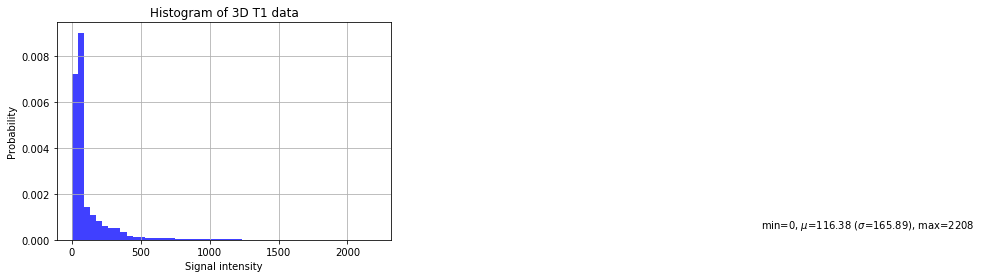

In [181]:
# the histogram of the 3D T1 data

x = data.flatten()
m, bins, patches = plt.hist(x, 50, density=True, facecolor='b', alpha=0.75)

mn = np.min(x)
mx = np.max(x)
mu = np.mean(x)
s = np.std(x)
txt = 'min=%d, $\mu$=%0.2f ($\sigma$=%0.2f), max=%d' % (mn, mu, s, mx)
plt.xlabel('Signal intensity')
plt.ylabel('Probability')
plt.title('Histogram of 3D T1 data')
plt.text(5000, .0005, txt)
plt.grid(True)
plt.show()